In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
import seaborn as sns
from scipy import spatial
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

In [67]:
# item alpha = 5.97e-05
model = pd.read_pickle(f'/pio/scratch/1/i313924/data/lightfm_data/model_25_epochs_optimal_hyperparams_categories_item_alpha_5.97e-05.pkl')

In [68]:
len(model.item_embeddings[model.item_embeddings > 10])

1053

In [69]:
len(model.item_embeddings[model.item_embeddings > 100])

876

In [70]:
# item alpha = 0
model = pd.read_pickle(f'/pio/scratch/1/i313924/data/lightfm_data/model_50_epochs_optimal_hyperparams_categories_item_alpha_0.pkl')

In [71]:
len(model.item_embeddings[model.item_embeddings > 10])

534

In [72]:
len(model.item_embeddings[model.item_embeddings > 100])

0

## Analyse word2vec with categories

In [43]:
word2vec_embeddings = pd.read_parquet('/pio/scratch/1/i313924/data/word2vec/word2vec_240_embeddings_categories.parquet')
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [44]:
grouped = word2vec_embeddings.join(categories.set_index('asin')).groupby('category_1')

In [45]:
item_embeddings = pd.DataFrame()
for g in grouped:
    item_embeddings = pd.concat([item_embeddings, g[1] + word2vec_embeddings.loc[g[0]]])

In [46]:
item_embeddings = item_embeddings.loc[:, ~item_embeddings.columns.isin(['category_1', 'category_2'])]

In [53]:
item_pca = PCA(n_components=2)
item_pca.fit(item_embeddings)
transformed = pd.DataFrame(item_pca.transform(item_embeddings))
transformed.index = item_embeddings.index
transformed = transformed.join(categories.set_index('asin'))
transformed.columns = ['0', '1', 'category_1', 'category_2']

<AxesSubplot:xlabel='0', ylabel='1'>

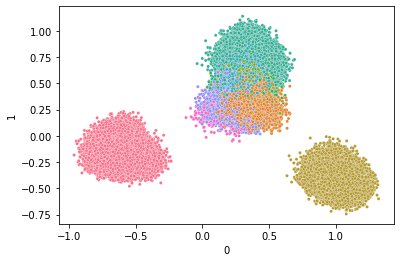

In [55]:
sns.scatterplot(x='0', y='1', data=transformed, hue='category_1', s=10, legend=False)

In [51]:
item_embeddings = item_embeddings.drop_duplicates()

In [56]:
def analyse_ABX(path, items_embeddings, pca):
    abx_tests = pd.read_json(path, lines=True)
    A = np.zeros((10000, 240))
    B = np.zeros((10000, 240))
    X = np.zeros((10000, 240))

    for i, test in abx_tests.iterrows():
        A[i, :] = items_embeddings.loc[test["A"]]
        B[i, :] = items_embeddings.loc[test["B"]]
        X[i, :] = items_embeddings.loc[test["X"]]

    dist_A = ((A - X) ** 2).sum(axis=1)
    dist_B = ((B - X) ** 2).sum(axis=1)

    cos_dist_A = np.zeros(10000)
    cos_dist_B = np.zeros(10000)

    for i in range(10000):
        cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
        cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

    if pca is not None:
        pca_A = pca.transform(A)
        pca_B = pca.transform(B)
        pca_X = pca.transform(X)

        dist_pca_A = ((pca_A - pca_X) ** 2).sum(axis=1)
        dist_pca_B = ((pca_B - pca_X) ** 2).sum(axis=1)

        cos_dist_pca_A = np.zeros(10000)
        cos_dist_pca_B = np.zeros(10000)

        for i in range(10000):
            cos_dist_pca_A[i] = spatial.distance.cosine(pca_A[i, :], pca_X[i, :])
            cos_dist_pca_B[i] = spatial.distance.cosine(pca_B[i, :], pca_X[i, :])

    return [(dist_A < dist_B).mean(), (dist_pca_A < dist_pca_B).mean(),
            ((dist_A < dist_B) == (dist_pca_A < dist_pca_B)).mean()], [(cos_dist_A < cos_dist_B).mean(),
                                                                       (cos_dist_pca_A < cos_dist_pca_B).mean(), (
                                                                                   (cos_dist_A < cos_dist_B) == (
                                                                                       cos_dist_pca_A < cos_dist_pca_B)).mean()]


analyse_ABX('/pio/scratch/1/recommender_systems/interim/ABX_tests/5_core.json', item_embeddings, item_pca)

([1.0, 0.9795, 0.9795], [1.0, 0.9678, 0.9678])